In [1]:
import os
import time

import torch
import torchvision.utils as tvutils
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset
from torch import nn

import cv2
import PIL
import matplotlib.pyplot as plt

from my_utils import data, models

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)  # set default size of plots

# life save magic code
%load_ext autoreload
%autoreload 2

In [2]:
UseGPU = torch.cuda.is_available()
device = torch.device("cuda" if UseGPU else "cpu")
print(f"Using {device} now!")

Using cuda now!


In [3]:
batch_size = 128
fig_resize = 32
T = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((fig_resize, fig_resize))
])
loader_kwargs = {
    'batch_size': batch_size,
    'shuffle': True,
    'num_workers': 4,
    'pin_memory': False,
    'drop_last': True
}

In [4]:
# 制作二进制数据集
train_data = data.MyDataset('Datasets/polygons_unfilled_32/train', transform=T)
train_loader = DataLoader(train_data, **loader_kwargs)

val_data = data.MyDataset('Datasets/polygons_unfilled_32/val', transform=T)
val_loader = DataLoader(val_data, **loader_kwargs)

test_data = data.MyDataset('Datasets/polygons_unfilled_32/test', transform=T)
test_loader = DataLoader(test_data, **loader_kwargs)

In [35]:
train_data = ImageFolder('Datasets/polygons_unfilled_32/train/', transform=T)  # 10000 * 6
train_loader = DataLoader(train_data, **loader_kwargs)

val_data = ImageFolder('Datasets/polygons_unfilled_32/val/', transform=T)
val_loader = DataLoader(val_data, **loader_kwargs)

test_data = ImageFolder('Datasets/polygons_unfilled_32/test/', transform=T)
test_loader = DataLoader(test_data, **loader_kwargs)

In [5]:
sample_step = 10

small_train_data = Subset(train_data, torch.arange(0, len(train_data) - 1, sample_step))
small_train_loader = DataLoader(small_train_data, **loader_kwargs)

small_val_data = Subset(val_data, torch.arange(0, len(val_data) - 1, sample_step))
small_val_loader = DataLoader(small_val_data, **loader_kwargs)

In [7]:
# check data before training!
img, label = train_data[0]
print(len(train_data), '\t', img.shape)
imgs, labels = next(iter(train_loader))
print(len(train_loader), '\t', imgs.shape)

img, label = val_data[0]
print(len(val_data), '\t', img.shape)
imgs, labels = next(iter(val_loader))
print(len(val_loader), '\t', imgs.shape)

50000 	 torch.Size([1, 32, 32])
390 	 torch.Size([128, 1, 32, 32])
10000 	 torch.Size([1, 32, 32])
78 	 torch.Size([128, 1, 32, 32])


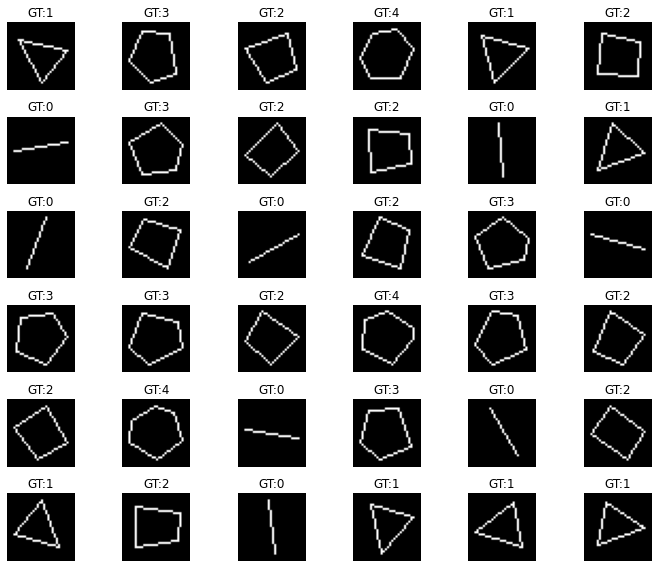

In [9]:
vis = imgs.permute(0, 2, 3, 1)
fig = plt.figure()
for i in range(36):
    plt.subplot(6, 6, i+1)
    plt.title(f"GT:{labels[i]}")
    plt.imshow(vis[i], 'gray')
    plt.axis('off')
plt.tight_layout()

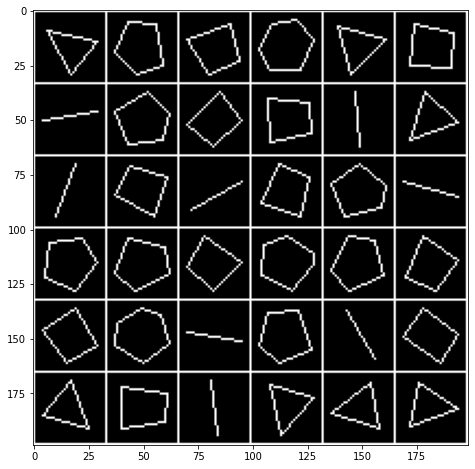

In [10]:
imgs_grid = tvutils.make_grid(imgs[:36], nrow=6, padding=1, pad_value=1)
plt.imshow(imgs_grid.permute(1,2,0))

In [11]:
model = models.Conv(in_channel=1, class_num=5, fig_size=fig_resize).to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.1)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.1)
loss_func = nn.MSELoss()

In [9]:
def train(train_loader, epoch, print_every=10):
    model.train()
    epoch_loss = 0
    loss_hist, train_acc_hist, val_acc_hist = [], [], []
    tic = time.time()
    for batch_idx, (X, Y) in enumerate(train_loader):
        X = X.to(device, dtype=torch.float32)
        Y = Y.to(device, dtype=torch.int)
        pred = model(X).squeeze()
        loss = loss_func(pred, Y)
        loss_hist.append(loss)
        epoch_loss += loss * batch_size

        # back propagate
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % print_every == 0:
            # check accuracy
            model.eval()
            train_acc = check_accuracy(small_train_loader, model)
            train_acc_hist.append(train_acc)
            val_acc = check_accuracy(small_val_loader, model)
            val_acc_hist.append(val_acc)
            print('Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.5f}\tVal acc: {:.1f}%'.format(
                epoch, batch_idx * batch_size, len(train_loader.dataset),
                       100. * batch_idx / len(train_loader),
                       loss, 100. * val_acc))
            model.train()

    print('====> Epoch: {}\tAverage loss: {:.4f}\tTime: {}s'.format(
        epoch, epoch_loss / len(train_loader.dataset), time.time() - tic))

    return loss_hist, train_acc_hist, val_acc_hist

In [21]:
def val(epoch):
    model.eval()
    val_loss, val_acc = 0, 0
    loss_history, acc_history = [], []
    with torch.no_grad():
        for batch_idx, (imgs, labels) in enumerate(val_loader):
            B = len(labels)
            imgs = imgs.to(device, dtype=torch.float32)
            labels = labels.to(device, dtype=torch.int)
            pred = model(imgs)
            loss = torch.mean((pred - labels) ** 2)
            val_loss += loss
            loss_history.append(loss.item() / B)
            # check accuracy
            acc = (pred.round().to(int) == labels).sum() / B
            val_acc += acc.item()
            acc_history.append(acc.item())

    val_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(val_loss))

    return loss_history

In [16]:
def check_accuracy(loader, test_model, ratio=0.1):
    # check_b = int(len(loader) * ratio)
    num_correct = 0
    num_samples = 0
    test_model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for batch_idx, (X, Y) in enumerate(loader):
            # if batch_idx == check_b:
            #     break
            X = X.to(device, dtype=torch.float32)  # move to device, e.g. GPU
            Y = Y.to(device, dtype=torch.int)
            preds = test_model(X).squeeze()
            num_correct += (preds.round().to(int) == Y).sum()
            num_samples += len(preds)
        acc = float(num_correct) / num_samples
        # print('Got %d / %d correct (%.2f%%).' % (num_correct, num_samples, 100 * acc))

    return acc

In [43]:
# reset train history
train_loss_history, train_acc_history, val_acc_history = [], [], []

In [48]:
# Train and test!
num_epoch = 5
for epoch in range(1, num_epoch + 1):
    loss_hist, train_acc_hist, val_acc_hist = train(train_loader, epoch, print_every=50)
    train_loss_history.extend(loss_hist)
    train_acc_history.extend(train_acc_hist)
    val_acc_history.extend(val_acc_hist)
    # val_loss.extend(val(epoch))

Epoch: 1 [0/50000 (0%)]	Loss: 0.12397	Val acc: 34.9%
Epoch: 1 [6400/50000 (13%)]	Loss: 0.20569	Val acc: 38.2%
Epoch: 1 [12800/50000 (26%)]	Loss: 0.08903	Val acc: 80.2%
Epoch: 1 [19200/50000 (38%)]	Loss: 0.14036	Val acc: 78.1%
Epoch: 1 [25600/50000 (51%)]	Loss: 0.11351	Val acc: 61.9%
Epoch: 1 [32000/50000 (64%)]	Loss: 0.08630	Val acc: 76.9%
Epoch: 1 [38400/50000 (77%)]	Loss: 0.10234	Val acc: 80.2%
Epoch: 1 [44800/50000 (90%)]	Loss: 0.10056	Val acc: 86.5%
====> Epoch: 1	Average loss: 0.1266	Time: 75.4116632938385s
Epoch: 2 [0/50000 (0%)]	Loss: 0.12694	Val acc: 88.7%
Epoch: 2 [6400/50000 (13%)]	Loss: 0.11906	Val acc: 84.4%
Epoch: 2 [12800/50000 (26%)]	Loss: 0.09020	Val acc: 80.8%
Epoch: 2 [19200/50000 (38%)]	Loss: 0.20518	Val acc: 88.2%
Epoch: 2 [25600/50000 (51%)]	Loss: 0.10107	Val acc: 87.1%
Epoch: 2 [32000/50000 (64%)]	Loss: 0.13348	Val acc: 85.0%
Epoch: 2 [38400/50000 (77%)]	Loss: 0.09462	Val acc: 81.8%
Epoch: 2 [44800/50000 (90%)]	Loss: 0.09055	Val acc: 88.8%
====> Epoch: 2	Average l

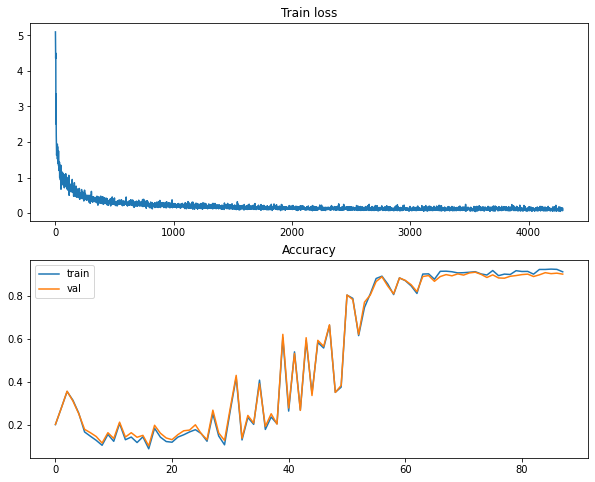

In [49]:
# plot train loss and test loss

fig = plt.figure()

plt.subplot(2, 1, 1)
plt.plot(train_loss_history)
plt.title("Train loss")

plt.subplot(2, 1, 2)
plt.plot(train_acc_history, label='train')
plt.plot(val_acc_history, label='val')
plt.title("Accuracy")
plt.legend()

plt.show()

In [18]:
imgs, labels = next(iter(test_loader))
preds = model(imgs.to(device)).squeeze()
p_labels = (preds).round().to('cpu', int)
print(p_labels, '\n', labels)
(p_labels == labels).sum() / len(labels)

tensor([8, 4, 8, 8, 4, 4, 6, 3, 9, 7, 6, 8, 7, 9, 6, 6, 7, 6, 6, 4, 4, 6, 8, 5,
        8, 6, 5, 6, 5, 7, 7, 8, 4, 4, 7, 4, 7, 6, 4, 7, 7, 8, 8, 5, 5, 9, 5, 6,
        4, 4, 7, 6, 8, 7, 7, 9, 6, 8, 8, 4, 5, 4, 9, 5, 8, 6, 3, 8, 6, 5, 5, 6,
        6, 6, 5, 4, 7, 6, 7, 8, 5, 5, 3, 4, 4, 8, 6, 4, 5, 8, 5, 6, 4, 4, 6, 8,
        3, 7, 4, 4, 8, 5, 4, 5, 4, 7, 5, 6, 8, 4, 7, 7, 6, 9, 7, 6, 6, 6, 7, 8,
        6, 9, 4, 6, 9, 4, 6, 8]) 
 tensor([5, 1, 5, 5, 1, 1, 4, 1, 6, 4, 4, 6, 4, 6, 4, 3, 5, 3, 4, 1, 1, 3, 6, 2,
        5, 4, 2, 3, 2, 5, 4, 6, 1, 1, 4, 1, 5, 3, 1, 4, 4, 6, 6, 2, 2, 6, 2, 4,
        1, 1, 5, 3, 5, 4, 5, 6, 4, 5, 6, 1, 2, 1, 6, 2, 5, 4, 1, 6, 3, 2, 3, 3,
        3, 3, 2, 1, 4, 3, 5, 5, 2, 3, 1, 1, 1, 6, 3, 1, 2, 6, 2, 4, 1, 1, 3, 6,
        1, 5, 1, 1, 6, 2, 1, 3, 1, 5, 2, 3, 6, 1, 5, 5, 4, 6, 5, 4, 3, 3, 5, 6,
        4, 6, 1, 4, 6, 1, 4, 5])


tensor(0.)

In [23]:
model.eval()
test_acc = check_accuracy(test_loader, model, ratio=1)
print('Test accuracy is : %.2f%%' % (100. * test_acc))

Test accuracy is : 87.09%


In [50]:
# Save weights of the model above
model_paras = model.state_dict()
print("Model parameters:")
for k, v in model_paras.items():
    print(f"{k}:\t {v.size()}")

optim_paras = optimizer.state_dict()
print("\nOptimizer parameters:")
for k, v in optim_paras.items():
    print(f"{k}")

save_time = time.strftime("%Y_%m_%d_%H_%M_%S", time.localtime())
save_path = "saved_models/angle_conv_" + save_time + ".pt"
torch.save({
    "model_paras": model_paras,
    "optim_paras": optim_paras
}, save_path)
print(f"\nSuccessfully saved to {save_path}")

Model parameters:
network.0.0.weight:	 torch.Size([6, 3, 3, 3])
network.0.0.bias:	 torch.Size([6])
network.0.1.weight:	 torch.Size([6])
network.0.1.bias:	 torch.Size([6])
network.0.1.running_mean:	 torch.Size([6])
network.0.1.running_var:	 torch.Size([6])
network.0.1.num_batches_tracked:	 torch.Size([])
network.1.0.weight:	 torch.Size([8, 6, 3, 3])
network.1.0.bias:	 torch.Size([8])
network.1.1.weight:	 torch.Size([8])
network.1.1.bias:	 torch.Size([8])
network.1.1.running_mean:	 torch.Size([8])
network.1.1.running_var:	 torch.Size([8])
network.1.1.num_batches_tracked:	 torch.Size([])
network.2.0.weight:	 torch.Size([8, 8, 3, 3])
network.2.0.bias:	 torch.Size([8])
network.2.1.weight:	 torch.Size([8])
network.2.1.bias:	 torch.Size([8])
network.2.1.running_mean:	 torch.Size([8])
network.2.1.running_var:	 torch.Size([8])
network.2.1.num_batches_tracked:	 torch.Size([])
network.4.weight:	 torch.Size([1, 8192])
network.4.bias:	 torch.Size([1])

Optimizer parameters:
state
param_groups

Succ

In [34]:
# reload modal paras from saved .pt file
new_model = models.Conv()

new_model.to(device)
new_optimizer = torch.optim.Adam(new_model.parameters())

save_path = 'saved_models/angle_conv_2021_12_20_01_54_47.pt'
checkpoint = torch.load(save_path)
new_model.load_state_dict(checkpoint["model_paras"])
new_optimizer.load_state_dict(checkpoint["optim_paras"])

RuntimeError: Error(s) in loading state_dict for Conv:
	Missing key(s) in state_dict: "layer1.0.weight", "layer1.1.weight", "layer1.1.bias", "layer1.1.running_mean", "layer1.1.running_var", "layer2.0.weight", "layer2.1.weight", "layer2.1.bias", "layer2.1.running_mean", "layer2.1.running_var", "layer3.0.weight", "layer3.1.weight", "layer3.1.bias", "layer3.1.running_mean", "layer3.1.running_var", "regression.1.weight", "regression.1.bias". 
	Unexpected key(s) in state_dict: "network.0.0.weight", "network.0.0.bias", "network.0.1.weight", "network.0.1.bias", "network.0.1.running_mean", "network.0.1.running_var", "network.0.1.num_batches_tracked", "network.1.0.weight", "network.1.0.bias", "network.1.1.weight", "network.1.1.bias", "network.1.1.running_mean", "network.1.1.running_var", "network.1.1.num_batches_tracked", "network.2.0.weight", "network.2.0.bias", "network.2.1.weight", "network.2.1.bias", "network.2.1.running_mean", "network.2.1.running_var", "network.2.1.num_batches_tracked", "network.4.weight", "network.4.bias". 

In [15]:
new_model.eval()
test_acc = check_accuracy(test_loader, new_model, ratio=1)
print('Test accuracy is : %.2f%%' % (100. * test_acc))

Test accuracy is : 85.90%


In [27]:
imgs, labels = next(iter(test_loader))
preds = new_model(imgs.to(device)).squeeze()

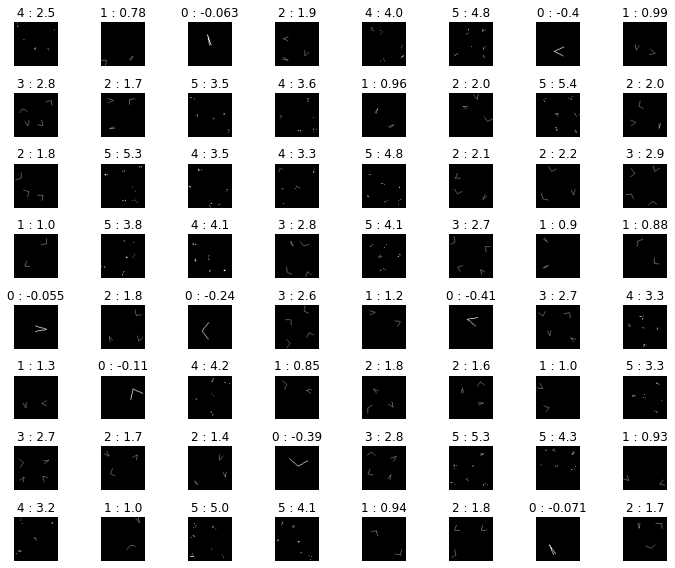

In [28]:
vis = imgs.permute(0, 2, 3, 1)
fig = plt.figure()
for i in range(64):
    plt.subplot(8, 8, i+1)
    plt.title(f"{labels[i]} : {preds[i]:.2}")
    plt.imshow(vis[i])
    plt.axis('off')
plt.tight_layout()